In [1]:
from train import *
from model import *
from helpers import *

import os
import plac
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path
from IPython.display import clear_output

import numpy as np
from PIL import Image

import torch
from torch import nn, Tensor
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torchvision.utils import make_grid
import torchvision.utils as vutils
import torchvision.datasets as dset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
else:
    dtype = torch.FloatTensor

num GPUs 2
num GPUs 2


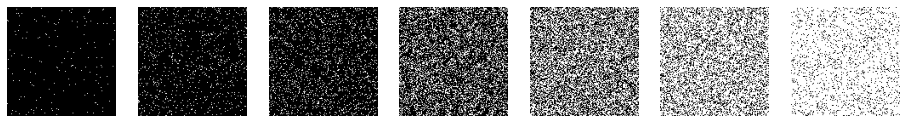

In [2]:
num_of_low_shots = 64
num_of_val = 24
image_size = 128

# given mask
img_mask_pil = Image.open('./mask.png')
mask_np = pil_to_np(img_mask_pil)
mask_var = np_to_var(mask_np).type(dtype) # float within 0~1

# random masks
ratios = np.array([0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9])
masks = torch.zeros(len(ratios), 3, image_size, image_size).to(device)

plt.figure(figsize=(16, 8))
for i in range(len(masks)):
    plt.subplot(1, len(masks), i + 1)
    tmp = torch.cuda.FloatTensor(1, 1, image_size, image_size).uniform_() < ratios[i]
    tmp = tmp.view(-1, 1, 128, 128)
    
    mask_np = var_to_np(tmp)
    mask_np = np.array([mask_np[0,:,:] / np.max(mask_np) ] * 3)
    masks[i] = np_to_var(mask_np).type(dtype)

    plt.imshow(mask_np.transpose(1, 2, 0))
    plt.axis('off');

In [3]:
# low shots
# Root directory for dataset
data_root = "./CelebA_data/celeba"

batch_size = 2
data_set = dset.ImageFolder(root=data_root,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor() ]))

train_set = IndexedDataset(torch.utils.data.Subset(data_set, range(52, 52+num_of_low_shots, 1)))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

# validate images
val_set = IndexedDataset(torch.utils.data.Subset(data_set, range(27, 51, 1)))
val_loader = torch.utils.data.DataLoader(val_set, shuffle=False, batch_size=1)

In [4]:
code_dim = 128
Z = np.random.normal(size=(len(train_set), 1, code_dim)).astype(np.float32) # (number of low shots, 128)
Z = torch.tensor(Z, requires_grad=True).to(device)

LV_Z = LatentVariables(Z).to(device)
pretrain_decoder = Decoder(code_dim).to(device)

g = CombinedModel(LV_Z, pretrain_decoder).to(device)
g.apply(weight_init)
print(get_n_params(g))
print(g)

13253504
CombinedModel(
  (Z): LatentVariables()
  (Decoder): Decoder(
    (dcnn): Sequential(
      (0): ConvTranspose2d(128, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
      (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU(inplace=True)
      (12): ConvTranspose2d(

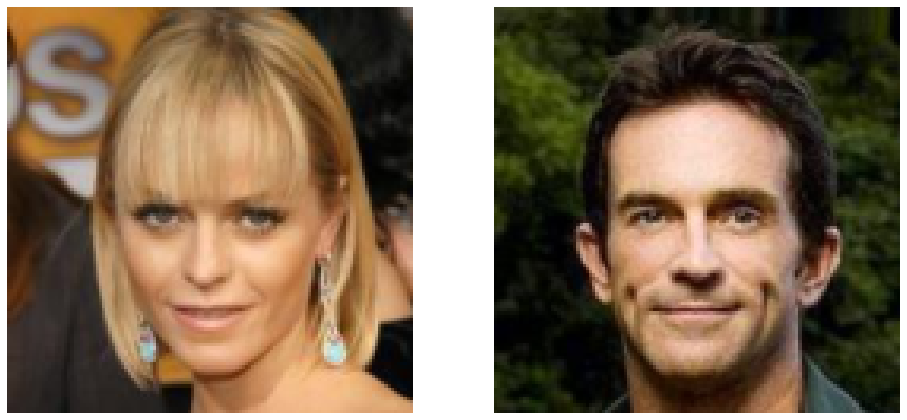

In [6]:
# prepare for pre-train
loss_fn = nn.MSELoss()

learning_rate = 1e-4
optimizer = torch.optim.Adam(g.parameters(), lr=learning_rate, weight_decay=4e-5)

Xi_train, _, _ = (next(iter(train_loader))) # Xi_val: [3, 3, 128, 128]
train_image_index = np.arange(0, len(train_set))

# low shots in the current training batch
plt.figure(figsize=(16, 8))
for i in range(len(Xi_train)):
    plt.subplot(1, len(Xi_train), i + 1)
    imgshow(Xi_train[i])
    plt.axis('off');

In [7]:
# pre-train
epoch_for_pre = 6000
g, Z = pre_train(epoch_for_pre, 
                 train_loader, 
                 g, 
                 Z,
                 train_image_index,
                 optimizer, 
                 pretrain_decoder,
                  "./low_shots_celeb/checkpoint/current_decoder_pre_64_shots.pt")

Pre-train Epoch: 200 	 Average Loss: 0.001451
Pre-train Epoch: 400 	 Average Loss: 0.001096
Pre-train Epoch: 600 	 Average Loss: 0.000872
Pre-train Epoch: 800 	 Average Loss: 0.000829
Pre-train Epoch: 1000 	 Average Loss: 0.000848
Pre-train Epoch: 1200 	 Average Loss: 0.000819
Pre-train Epoch: 1400 	 Average Loss: 0.000731
Pre-train Epoch: 1600 	 Average Loss: 0.000751
Pre-train Epoch: 1800 	 Average Loss: 0.000623
Pre-train Epoch: 2000 	 Average Loss: 0.000677
Pre-train Epoch: 2200 	 Average Loss: 0.000682
Pre-train Epoch: 2400 	 Average Loss: 0.000734
Pre-train Epoch: 2600 	 Average Loss: 0.000718
Pre-train Epoch: 2800 	 Average Loss: 0.000759
Pre-train Epoch: 3000 	 Average Loss: 0.000541
Pre-train Epoch: 3200 	 Average Loss: 0.009741
Pre-train Epoch: 3400 	 Average Loss: 0.000592
Pre-train Epoch: 3600 	 Average Loss: 0.000642
Pre-train Epoch: 3800 	 Average Loss: 0.006406
Pre-train Epoch: 4000 	 Average Loss: 0.000791
Pre-train Epoch: 4200 	 Average Loss: 0.000575
Pre-train Epoch: 

In [8]:
# prepare for training
loss_fn = nn.MSELoss()
code_dim = 128
epoch_for_train_z = 1250
epoch_for_joint_train = 350

# final_output = torch.zeros((len(val_set), 3, 128, 128)).to(device)
# final_z_dict = torch.zeros((len(val_set), 1, code_dim)).to(device)


def train_all_val(mask):
    psnr_list = np.zeros(len(val_set))
    mask = mask.to(device)
    for i, (Xi_val, _, idx_val) in enumerate(val_loader):
        progress = tqdm(total=1, desc='loop % 3d' % i)
        # for image i
        Xi_val = Variable(Xi_val).to(device)
        Xi_val_noisy = (Xi_val * mask).to(device)

        # load pre-trained decoder
        train_decoder = Decoder(code_dim).to(device)
        if os.path.isfile("./low_shots_celeb/checkpoint/current_decoder_pre_64_shots.pt"):
            train_decoder.load_state_dict(torch.load("./low_shots_celeb/checkpoint/current_decoder_pre_64_shots.pt"))
        else:
            train_decoder.apply(weight_init)

        # initial z
        target_z = sample_multivar_normal(Z)

        # combined model train_g
        LV_target_z = LatentVariables(target_z).to(device)
        train_g = CombinedModel(LV_target_z, train_decoder).to(device)

        # train phase: train z to find z_hat
        target_z_hat, _ = train(epoch_for_train_z, 
                                Xi_val_noisy, 
                                train_g, 
                                train_decoder, 
                                target_z, 
                                joint_train=False,
                                learning_rate=5 * 1e-4,
                                save_path="./low_shots_celeb/checkpoint/current_checkpoint_train_z.pt",
                                mask=mask,
                                measure=None)

        # train phase: joint train
        warm_start_z = LatentVariables(target_z_hat).to(device)
        joint_train_g = CombinedModel(warm_start_z, train_decoder).to(device)

        final_z, final_G = train(epoch_for_joint_train, 
                             Xi_val_noisy, 
                             joint_train_g,
                             train_decoder, 
                             target_z_hat, 
                             joint_train=True,
                             learning_rate=1e-4,
                             save_path="./low_shots_celeb/checkpoint/current_checkpoint_final.pt",
                             mask=mask,
                             measure=None)

#         final_output[i] = final_G
#         final_z_dict[i] = final_z
        psnr_list[i] = psnr(Xi_val.cpu().numpy(), final_G.detach().cpu().numpy())

        progress.set_postfix({'loss': loss_fn(final_G * mask, Xi_val* mask).item()})
        progress.update()
        
    return np.mean(psnr_list)

In [9]:
average_pnsr_list = []
for ratio, mask in zip(ratios, masks):
    print("for ratio:", ratio)
    snr = train_all_val(mask)
    average_pnsr_list.append(snr)
    print("psnr = ", snr)
    clear_output(wait=True)

for ratio: 0.9


psnr =  42.19759743056951


[15.7392114596732, 19.342492635794994, 21.83152919599549, 27.666659584064607, 33.61539222139005, 38.05694642591559, 42.19759743056951]


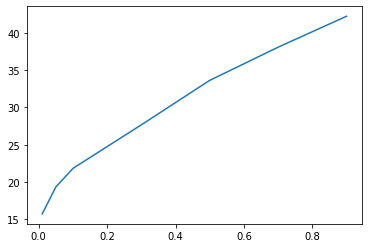

In [10]:
print(average_pnsr_list)
plt.plot(ratios, average_pnsr_list)

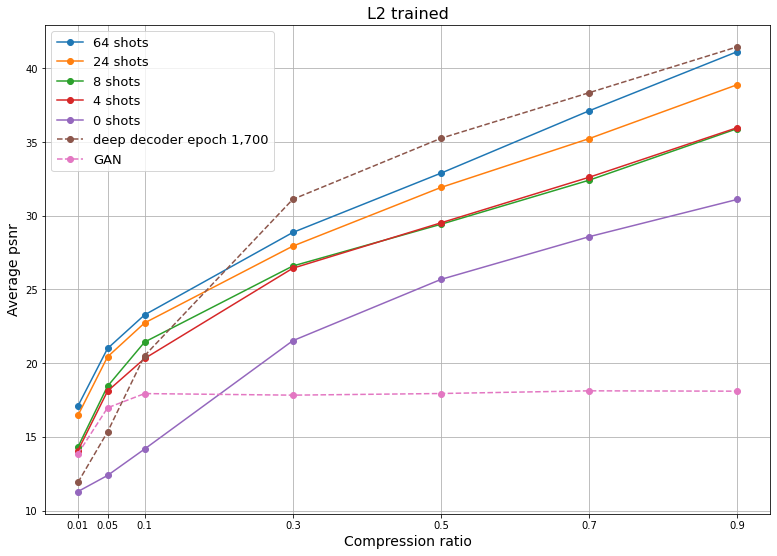

In [13]:
# average psnr on 24 validation plots
ratios = np.array([0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9])
plt.figure(figsize=(13, 9))

average_pnsr_list_64_shots = [17.087595079430194, 20.992962846857825, 23.272101668243057, 28.862349177119086, 32.88639329306287, 37.11627794405722, 41.13012122489318]
average_pnsr_list_24_shots = [16.450189320717083, 20.42730040384058, 22.72519374467173, 27.934608780098362, 31.916842334983887, 35.22947719215666, 38.8890832840332]
average_pnsr_list_8_shots = [14.307779667386264, 18.43404431843833, 21.427811301422064, 26.58693752783705, 29.41867431265356, 32.40906964759061, 35.90712862381694]
average_pnsr_list_4_shots = [14.062939434376647, 18.101784833867118, 20.312286170392714, 26.435246216982094, 29.516358193901198, 32.60759296333913, 35.972687653502504]
average_pnsr_list_0_shots = [11.285993387963197, 12.379572090471278, 14.171125486758266, 21.51982343421712, 25.678263890672856, 28.575814761878963, 31.104419523631993]
average_pnsr_list_deep_decoder_1700 = [11.904032281201125, 15.335027713208218, 20.50280929965433, 31.111607866187303, 35.24971433970376, 38.34396487921627, 41.456362370688346]
average_pnsr_list_gan = [13.84896312083876, 16.9682398054929, 17.932426198519966, 17.825612643046718, 17.937032342377737, 18.119387271749073, 18.09500850959046]
plt.plot(ratios, average_pnsr_list_64_shots, marker='o')
plt.plot(ratios, average_pnsr_list_24_shots, marker='o')
plt.plot(ratios, average_pnsr_list_8_shots, marker='o')
plt.plot(ratios, average_pnsr_list_4_shots, marker='o')
plt.plot(ratios, average_pnsr_list_0_shots, marker='o')
plt.plot(ratios, average_pnsr_list_deep_decoder_1700, linestyle='dashed', marker='o')
plt.plot(ratios, average_pnsr_list_gan, linestyle='dashed', marker='o')
plt.xlabel('Compression ratio', fontsize=14)
plt.xticks(ratios, ratios)
plt.ylabel('Average psnr', fontsize=14)
plt.title('L2 trained', fontsize=16)
plt.legend(['64 shots', '24 shots', '8 shots', '4 shots', '0 shots', 'deep decoder epoch 1,700', 'GAN'], fontsize=13)
plt.grid()
plt.show()
